# Test, baseline, a subset of data

## Goals
 * Read data
 * Parse data
 * Preprocess
 * Vectorize
 * Cluster
 * Visualize

### Resources:
CSC Pebbles - Interactive research notebooks on demand from cloud:
https://pb.csc.fi/#/dashboard

Example notebook:
  Intro to Python, 8 - Pandas
  
Interactive notebooks for data analysis:
http://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261

#### Read data and parse as simple dictionary

In [1]:
import pprint
import re

filename = '../data/SuomiRyväsData2000'

opening_line = r'[ ]{,11}\d{,12} (?P<identifier>\d{15})'   # Note here is re.match(opening_line).group('identifier')
journal_line = r'Lehti: (.*)'
issn_line = r'ISSN: (.*)'
discipline_line = r'Ala: (.*)'
year_line = r'Ilmestymisvuosi:[ ]*(\d{1,4})'
title_line = r'Otsikko: (.*)'
abstract_line = r'Abstrakti'
keyword_publisher_line = r'Avainsana \(KeywordPlus\):  (.*)'
keyword_line = r'Avainsana \(tekijät\):  (.*)'
reference_line = r'Lähde: (.*)'
closing_line = r' * '


def dataset(batch_size=20):
    datasets = []
    data = {'keyword_publisher': '',
            'keyword': '',
            'reference': ''}
            #'discipline': '',}
    k = 0
    with open(filename) as f:
        for line in f:
            m = re.match(opening_line, line)
            if m:
                data['id'] = m.group('identifier')
                continue

            m = re.match(issn_line, line)
            if m:
                data['issn'] = m.group(1)
                continue

            # m = re.match(discipline_line, line)
            # if m:
            #     data['discipline'] = ' '.join([data['discipline'], m.group(1).replace(' & ', '_&_')])
            #     continue

            # Note: remeber to parse two character words too 'chromosome arm 3p'
            m = re.match(title_line, line)
            if m:
                data['title'] = m.group(1)
                continue

            # Note: remeber to parse two character words too 'chromosome arm 3p'
            m = re.match(abstract_line, line)
            if m:
                data['abstract'] = f.next()
                continue

            m = re.match(keyword_publisher_line, line)
            if m:
                data['keyword_publisher'] = ' '.join([data['keyword_publisher'], m.group(1).replace(' ', '_')])
                continue

            m = re.match(keyword_line, line)
            if m:
                data['keyword'] = ' '.join([data['keyword'], m.group(1).replace(' ', '_')])
                continue

            m = re.match(reference_line, line)
            if m:
                ref = re.sub('(\d+) /.*', '\\1', m.group(1))
                data['reference'] = ' '.join([data['reference'], ref.replace(' ', '_')])
                continue

            m = re.match(closing_line, line)
            if m:
                datasets.append(data.copy())
                k += 1
            if k >= batch_size:
                break
    return datasets

n_samples = 70
data = dataset(batch_size=n_samples)
print 'Raw data:'
print(79 * '-')
with open(filename) as f:
    for i2, line2 in enumerate(f):
        print line2
        if i2 > 22: break
print '\n\nParsed data:'
print(79 * '-')        
pprint.pprint(data[1:2])

Raw data:
-------------------------------------------------------------------------------
       10456

           1 084275900007000          

Lehti: ACTA OPHTHALMOLOGICA SCANDINAVICA

ISSN: 1395-3907

Ala: OPHTHALMOLOGY

Ilmestymisvuosi:   1999

Otsikko: Assessment of diabetic retinopathy using two-field 60 degrees fundus photography. A comparison between red-free, black-and-white prints and colour transparencies

Abstrakti

Purpose: To assess the severity of diabetic retinopathy and maculopathy bycomparing two different photographic methods; two-field 60 degrees photography using red-free, black-and-white prints and colour transparencies.Methods: Two ophthamologists independently graded the photographs of 74 patients using grading scales for retinopathy and maculopathy designed for 60degrees photography. A set of nine 60 degrees red-free, black-and-white standard photographs were chosen to represent the severity of principal diabetic retinopathy and maculopathy abnormalities.Results


#### Preprocess
Implement a scikit-learn Transformer and FeatureUnion to more sophisticately vectorize and wheigh features.

#### Vectorize and cluster in a pipeline

training time:  0.29s,    n_samples: 70
predict time: 9.96s


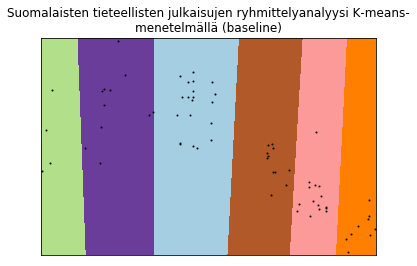

plot time: 12.98s


In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import (DictVectorizer,
                                        FeatureHasher)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline


class DisciplineExtractor(BaseEstimator, TransformerMixin):
    """Extract the discipline from data"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        transformed = []
        for d in data:
            transformed.append(d['discipline'])
        return transformed
    
class GeneralExtractor(BaseEstimator, TransformerMixin):
    """Extract and merge all fields from a sample to a string"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        transformed = []
        for d in data:
            transformed.append(' '.join(d.values()))
        return transformed    

n_cl = 6
pl = Pipeline([
    # ('discipline', DisciplineExtractor()),
    ('takeall', GeneralExtractor()),
    ('vectorizer', CountVectorizer()),
    ('svd', TruncatedSVD(n_components=2))
    # ('kmeans', KMeans(init='k-means++', n_clusters=n_cl, n_init=10))
    ])

t0 = time()
reduced_data = pl.fit_transform(data)
# Get timings for different clusterings: full dimensions, dimension reduced
t_preprocessing = time() - t0

# Visualize the results
#kmeans = KMeans(init='k-means++', n_clusters=n_cl, n_init=10)
kmeans = KMeans(init='random', n_clusters=n_cl, n_init=10)
kmeans.fit(reduced_data)
t_end = time() - t0; t1 = time()
print('training time:  %.2fs,    n_samples: %i' % (t_end, len(reduced_data)))

h = .02
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
t2 = time()
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
print('predict time: %.2fs' % (time() - t2))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.title(u'Suomalaisten tieteellisten julkaisujen ryhmittelyanalyysi K-means-\n'
          u'menetelmällä (baseline)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()
print('plot time: %.2fs' % (time() - t1))

In [3]:
print kmeans.labels_

[1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5
 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
